In [103]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Oct  7 15:53:21 2016

@author: dean
"""

import matplotlib.pyplot as plt 
import numpy as np
from itertools import product
import matplotlib.gridspec as gridspec
import pandas as pd

def naked_plot(axes):
    for ax in  axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
def fit_axis(ax, x, y, x_ax=True, y_ax=True, unity_ax=False):
    maxest = max([max(x), max(y)])
    minest = min([min(x), min(y)])
    if unity_ax:
        ax.plot([minest,maxest],[minest,maxest], lw=0.1, color='k');
    if min(y)<0:
        ax.plot([min(x),max(x)],[0,0], lw=.3, color='k');
    if min(x)<0:
        ax.plot([0,0],[min(y),max(y)], lw=.3, color='k');

def simple_hist_pd(ax, var, orientation='vertical', fontsize=10):
    n = ax.hist(var,histtype='step', align='mid',lw=0.5, 
                bins='auto', orientation=orientation)[0]
    sigfig = 4
    naked_plot([ax,])
    the_range = [min(var), max(var)]
    if orientation[0]=='v':  
        ax.set_ylim(0, max(n)+max(n)*.15)
        ax.set_xlim(the_range)
        ax.text(np.max(var), -ax.get_ylim()[1]/10, np.round(np.max(var),sigfig),ha='right',va='top', fontsize=fontsize )
        ax.text(np.min(var), -ax.get_ylim()[1]/10, np.round(np.min(var),sigfig),  ha='left',va='top', fontsize=fontsize)
        spine_loc = 'bottom'
    else:
        ax.set_xlim(0, max(n)+max(n)*.15)
        ax.set_ylim(the_range)
        ax.text(-ax.get_xlim()[1]/10, np.max(var), np.round(np.max(var), sigfig),  ha='right',va='top', fontsize=fontsize )
        ax.text(-ax.get_xlim()[1]/10, np.min(var), np.round(np.min(var), sigfig),  ha='right',va='bottom', fontsize=fontsize)
        spine_loc = 'left'
    ax.spines[spine_loc].set_visible(True)
    ax.spines[spine_loc].set(lw=0.5)
    ax.spines[spine_loc].set_bounds(the_range[0], the_range[1])
    
def small_mult_scatter_w_marg_pd(x, y):
    m = y.shape[1]+1
    n = x.shape[1]+1
    left_bottom = m*n-n
    y_hist_pos = list(range(0, m*n, n))[:-1]
    x_hist_pos = list(range(left_bottom+1, m*n))
    
    print(y_hist_pos)
    print(x_hist_pos)
    
    scatter_inds = np.sort(list(set(range(m*n)) - (set(x_hist_pos) | set(y_hist_pos) | set([left_bottom,]))))
    print(scatter_inds)
    cart_inds = list(product(range(m-1), range(n-1)))
    
    gs = gridspec.GridSpec(m, n, width_ratios=[1,]+[8,]*(n-1),
                            height_ratios=[8,]*(m-1)+[1,])
    
    plt.figure(figsize=(n*2,m*2))
    fontsize=10
    y_hists = []
    for y_col, pos in zip(y, y_hist_pos):
        _=plt.subplot(gs[pos])
        simple_hist_pd(_, y[y_col], orientation='horizontal')
        _.set_ylabel(str(y_col), rotation='horizontal', 
                     labelpad=fontsize*3, fontsize=fontsize)
        y_hists.append(_)
    x_hists = []
    
    for x_col, pos in zip(x, x_hist_pos):
        _ = plt.subplot(gs[pos])
        simple_hist_pd(_, x[x_col])
        _.set_xlabel(str(x_col), rotation='horizontal', 
                      fontsize=fontsize, labelpad=fontsize*2)
        x_hists.append(_)
    
    scatters = []    
    for (y_ind, x_ind), pos in zip(cart_inds, scatter_inds):
        _ = plt.subplot(gs[pos], sharex= x_hists[x_ind], sharey=y_hists[y_ind])
        _.scatter(x.iloc[:, x_ind], y.iloc[:, y_ind], s=0.4)
        fit_axis(_, x.iloc[:, x_ind], y.iloc[:, y_ind])
        scatters.append(_)
          
    naked_plot(scatters)
    
    return scatters, x_hists, y_hists



A linear model typically takes the form:

$$ y = X \beta + \epsilon$$

* $y$ is the data which here is assumed to be a linear function of the colums of $X$.
* $B$ is the vector of coeffecients that specify this function.
* $\epsilon$ is typically independent and identically distributed guassian noise,  independent of $y$.

In evaluating a fit we can check these assumptions, by making plots of diagnostic quantities for which normative values are well known.

<h4>Plotting the fit.</h4>
The first thing to do is plot the scatter of the fit.


(100, 1)
(100, 1)
(100, 1)
(100, 1)
(100, 1)
[0, 2, 4, 6, 8]
[11]
[1 3 5 7 9]


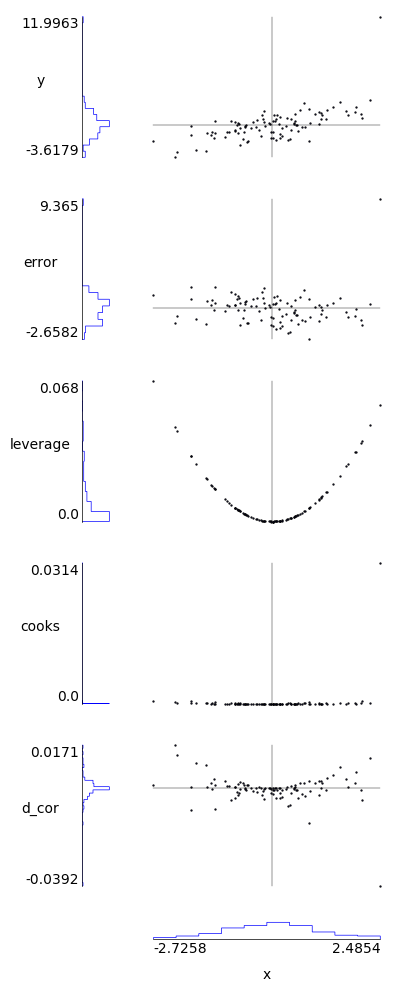

In [124]:
import numpy as  np
import scipy.io as  l
import os, sys
import scipy.stats
top_dir = os.getcwd().split('v4cnn')[0]
sys.path.append(top_dir + 'xarray')
top_dir = top_dir+ 'v4cnn/'
sys.path.append(top_dir)
sys.path.append(top_dir + 'common')
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline  
def linear_fit_an(x,y):
    x -= np.mean(x)
    y -= np.mean(y)
    b, res, rank, s = np.linalg.lstsq(x, y)
    y_hat = np.dot(x, b)
    e = y-y_hat
    inv_cov = np.linalg.inv(np.dot(x.T, x))
    H = np.dot(np.dot(x, inv_cov), x.T)
    h = np.expand_dims(H[np.diag_indices_from(H)],1)

    d = ((e**2) / (sum(e**2))*(h/((1-h)**2)))

    r = np.corrcoef(y.T, x.T)[0,1]
    d_cor = []
    for i in range(len(x)):
        y_i = [value for ind, value in enumerate(y) if ind!=i]
        x_i = [value for ind, value in enumerate(x) if ind!=i]
        d_cor.append(r - np.corrcoef(np.array(y_i).T, np.array(x_i).T)[0,1])
    d_cor = np.expand_dims(d_cor,1)
    [print(var.shape) for var in [y, e, h, d, d_cor]]
    dat = np.concatenate([y, e, h, d, d_cor], 1)

    df1 = pd.DataFrame(x, columns=['x'])
    df2 = pd.DataFrame(np.concatenate([y, e, h, d, d_cor], 1),
                       columns=['y', 'error', 'leverage', 'cooks', 'd_cor'])
    scatters, x_hists, y_hists = small_mult_scatter_w_marg_pd(df1, df2)
    
n = 100
outlier = np.zeros((n,1))
x = np.random.normal(size=(n,1))
x -= np.mean(x)
outlier[np.argmax(x)]=10
y = x + np.random.normal(size=(n,1)) + outlier
linear_fit_an(x,y)

0.184251965366
(80, 1)
(80, 1)
(80, 1)
(80, 1)
(80, 1)
[0, 2, 4, 6, 8]
[11]
[1 3 5 7 9]


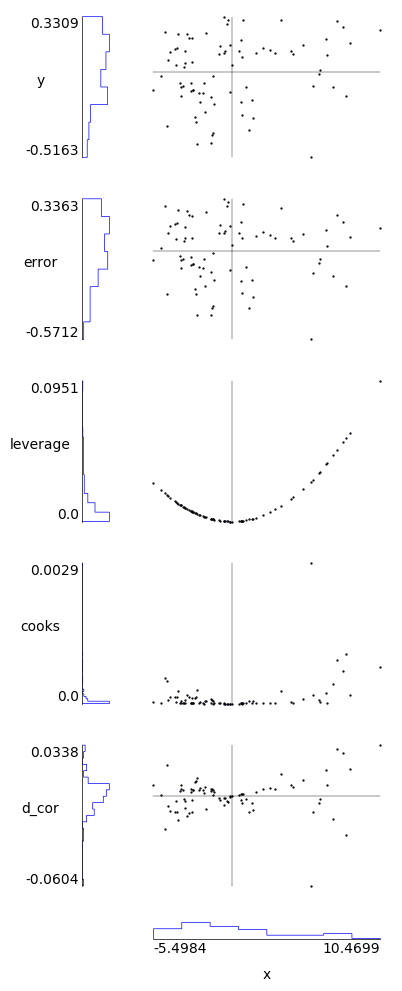

In [125]:
def norm_av_cov(unit, return_num_den=False):
    unit = unit.transpose('shapes','x')
    unit = unit.dropna('x', 'all').dropna('shapes', 'all').values
    cov = np.dot(unit.T, unit)
    cov[np.diag_indices_from(cov)] = 0
    numerator = np.sum(np.triu(cov))
    vlength = np.linalg.norm(unit, axis=0)
    max_cov = np.outer(vlength.T, vlength)
    max_cov[np.diag_indices_from(max_cov)] = 0
    denominator= np.sum(np.triu(max_cov))
    if return_num_den:
        return numerator, denominator
    else:
        return numerator/denominator
def kurtosis(da):
    da = da.dropna('shapes')
    da = da.transpose('shapes','unit')
    mu = da.mean('shapes')
    sig = da.reduce(np.nanvar, dim='shapes')
    k = (((da - mu)**4).sum('shapes',skipna=True)/da.shapes.shape[0])/(sig**2)
    return k
#lets find kurtosis of our SP
fn = top_dir +'data/responses/v4_ti_resp.nc'
v4 = xr.open_dataset(fn)['resp'].load()
v4 = v4.transpose('unit', 'x', 'shapes') 
v4 = v4 - v4.mean('shapes')
sp = v4.var('x')
k = kurtosis(sp)

av_cov = np.array([norm_av_cov(unit) for unit in v4])
plt.figure()
#plt.scatter(k, av_cov);plt.ylim(0,1);plt.ylabel('av cov');plt.xlabel('k');
#plt.title('r = ' +  str(np.corrcoef([k, av_cov])[0,1]))
print(np.corrcoef([k, av_cov])[0,1])
x = np.expand_dims(k,1)
y = np.expand_dims(av_cov, 1)
linear_fit_an(x, y)
